In [ ]:
import pandas as pd
print(pd. __version__)

1.5.3


In [ ]:
!python --version

Python 3.10.12


In [ ]:
import torch;
torch.__version__

'2.1.0+cu118'

In [ ]:
# ! git clone https://github.com/ayushkumartarun/zero-shot-unlearning.git

In [ ]:
# ! cd /content/zero-shot-unlearning

## dataset and basic function

CIFAR-10 dataset

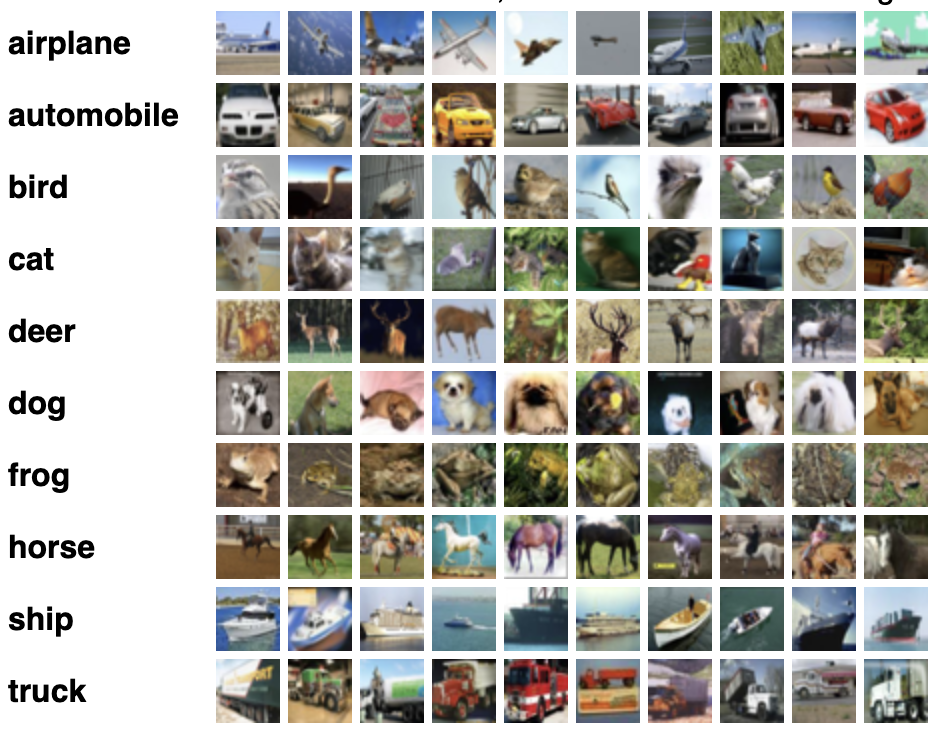

## Importing all the dataset

In [ ]:
import torchvision
import torchvision.transforms as tt
import tarfile
import os
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url

## Above image of dataset ##
def cifar10(root = './'):
    transform = tt.Compose([
        tt.ToTensor(),
        tt.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
    download_url(dataset_url, '.')

    # Extract from archive
    with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
        tar.extractall(path='./data')

    # Look into the data directory
    data_dir = os.path.join(root, 'data/cifar10')
    #print(os.listdir(data_dir))
    #classes = os.listdir(data_dir + "/train")

    #train_ds = torchvision.datasets.CIFAR10(root='./', train=True, download=True, transform=transform)
    #valid_ds = torchvision.datasets.CIFAR10(root='./', train=False, download=True, transform=transform)
    train_ds = ImageFolder(data_dir+'/train', transform)
    valid_ds = ImageFolder(data_dir+'/test', transform)
    return train_ds, valid_ds

## Street View House Numbers ##
def svhn(root = './'):
    transform = tt.Compose([
        tt.ToTensor(),
        tt.Normalize((0.4376821, 0.4437697, 0.47280442), (0.19803012, 0.20101562, 0.19703614))
    ])

    train_ds = torchvision.datasets.SVHN(root='./', train=True, download=True, transform=transform)
    valid_ds = torchvision.datasets.SVHN(root='./', train=False, download=True, transform=transform)

    return train_ds, valid_ds

## Modified National Institute of Standards and Technology database ##
## large database of handwritten digits
def mnist(root = './'):
    transform = tt.Compose([
        tt.ToTensor(),
    ])

    train_ds = torchvision.datasets.MNIST(root='./', train=True, download=True, transform=transform)
    valid_ds = torchvision.datasets.MNIST(root='./', train=False, download=True, transform=transform)

    return train_ds, valid_ds

## Important functions

Support vector machines (SVM)

SVC : C-Support Vector Classification.

In [ ]:
from sklearn.svm import SVC

## torch.where(condition, input, other, *, out=None) → Tensor
## entropy: measures the level of disorder or uncertainty in a given dataset or system
def entropy(p, dim = -1, keepdim = False):
    return -torch.where(p > 0, p * p.log(), p.new([0.0])).sum(dim=dim, keepdim=keepdim)

## torch.no_grad() is a loop
def collect_prob(data_loader, model):
    data_loader = torch.utils.data.DataLoader(data_loader.dataset, batch_size=1, shuffle=False, num_workers = 32, prefetch_factor = 10)
    prob = []
    with torch.no_grad():
        for batch in data_loader:
            batch = [tensor.to(next(model.parameters()).device) for tensor in batch]
            data, _, target = batch
            output = model(data)
            prob.append(F.softmax(output, dim=-1).data)
    return torch.cat(prob)

def get_membership_attack_data(retain_loader, forget_loader, test_loader, model):
    retain_prob = collect_prob(retain_loader, model)
    forget_prob = collect_prob(forget_loader, model)
    test_prob = collect_prob(test_loader, model)

    X_r = torch.cat([entropy(retain_prob), entropy(test_prob)]).cpu().numpy().reshape(-1, 1)
    Y_r = np.concatenate([np.ones(len(retain_prob)), np.zeros(len(test_prob))])

    X_f = entropy(forget_prob).cpu().numpy().reshape(-1, 1)
    Y_f = np.concatenate([np.ones(len(forget_prob))])
    return X_f, Y_f, X_r, Y_r

def get_membership_attack_prob(retain_loader, forget_loader, test_loader, model):
    X_f, Y_f, X_r, Y_r = get_membership_attack_data(retain_loader, forget_loader, test_loader, model)
    clf = SVC(C=3,gamma='auto',kernel='rbf')
    #clf = LogisticRegression(class_weight='balanced',solver='lbfgs',multi_class='multinomial')
    clf.fit(X_r, Y_r)
    results = clf.predict(X_f)
    return results.mean()

def relearn_time(model, train_loader, valid_loader, reqAcc, lr):
    # measuring relearn time for gold standard model
    rltime = 0
    curr_Acc = 0
    ## optimization using Adam
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)


    # we will try the relearning step till 4 epochs.
    for epoch in range(10):

        for batch in train_loader:
            model.train()
            loss = training_step(model, batch)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            history = [evaluate(model, valid_dl)]
            curr_Acc = history[0]["Acc"]*100
            print(curr_Acc, sep=',')



            rltime += 1
            if(curr_Acc >= reqAcc):
                break

        if(curr_Acc >= reqAcc):
            break
    return rltime

def ain(full_model, model, gold_model, train_data, val_retain, val_forget,
                  batch_size = 256, error_range = 0.05, lr = 0.001):
    # measuring performance of fully trained model on forget class
    forget_valid_dl = DataLoader(val_forget, batch_size)
    history = [evaluate(full_model, forget_valid_dl)]
    AccForget = history[0]["Acc"]*100

    print("Accuracy of fully trained model on forget set is: {}".format(AccForget))

    retain_valid_dl = DataLoader(val_retain, batch_size)
    history = [evaluate(full_model, retain_valid_dl)]
    AccRetain = history[0]["Acc"]*100

    print("Accuracy of fully trained model on retain set is: {}".format(AccRetain))

    history = [evaluate(model, forget_valid_dl)]
    AccForget_Fmodel = history[0]["Acc"]*100

    print("Accuracy of forget model on forget set is: {}".format(AccForget_Fmodel))

    history = [evaluate(model, retain_valid_dl)]
    AccRetain_Fmodel = history[0]["Acc"]*100

    print("Accuracy of forget model on retain set is: {}".format(AccRetain_Fmodel))

    history = [evaluate(gold_model, forget_valid_dl)]
    AccForget_Gmodel = history[0]["Acc"]*100

    print("Accuracy of gold model on forget set is: {}".format(AccForget_Gmodel))

    history = [evaluate(gold_model, retain_valid_dl)]
    AccRetain_Gmodel = history[0]["Acc"]*100

    print("Accuracy of gold model on retain set is: {}".format(AccRetain_Gmodel))

    reqAccF = (1-error_range)*AccForget

    print("Desired Accuracy for retrain time with error range {} is {}".format(error_range, reqAccF))

    train_loader = DataLoader(train_ds, batch_size, shuffle = True)
    valid_loader = DataLoader(val_forget, batch_size)
    rltime_gold = relearn_time(model = gold_model, train_loader = train_loader, valid_loader = valid_loader,
                               reqAcc = reqAccF,  lr = lr)

    print("Relearning time for Gold Standard Model is {}".format(rltime_gold))

    rltime_forget = relearn_time(model = model, train_loader = train_loader, valid_loader = valid_loader,
                               reqAcc = reqAccF, lr = lr)

    print("Relearning time for Forget Model is {}".format(rltime_forget))

    rl_coeff = rltime_forget/rltime_gold
    print("AIN = {}".format(rl_coeff))

In [ ]:
import torch
from torch import nn
import numpy as np


class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self,x):
        return x.view(x.size(0), -1)

class ConvStandard(nn.Conv2d):

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=None, output_padding=0, w_sig =\
                 np.sqrt(1.0)):
        super(ConvStandard, self).__init__(in_channels, out_channels,kernel_size)
        self.in_channels=in_channels
        self.out_channels=out_channels
        self.kernel_size=kernel_size
        self.stride=stride
        self.padding=padding
        self.w_sig = w_sig
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.normal_(self.weight, mean=0, std=self.w_sig/(self.in_channels*np.prod(self.kernel_size)))
        if self.bias is not None:
            torch.nn.init.normal_(self.bias, mean=0, std=0)

    def forward(self, input):
        return F.conv2d(input,self.weight,self.bias,self.stride,self.padding)

class Conv(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=None, output_padding=0,
                 activation_fn=nn.ReLU, batch_norm=True, transpose=False):
        if padding is None:
            padding = (kernel_size - 1) // 2
        model = []
        if not transpose:
#             model += [ConvStandard(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding
#                                 )]
            model += [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,
                                bias=not batch_norm)]
        else:
            model += [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding,
                                         output_padding=output_padding, bias=not batch_norm)]
        if batch_norm:
            model += [nn.BatchNorm2d(out_channels, affine=True)]
        model += [activation_fn()]
        super(Conv, self).__init__(*model)

class AllCNN(nn.Module):
    def __init__(self, filters_percentage=1., n_channels=3, num_classes=10, dropout=False, batch_norm=True):
        super(AllCNN, self).__init__()
        n_filter1 = int(96 * filters_percentage)
        n_filter2 = int(192 * filters_percentage)

        self.conv1 = Conv(n_channels, n_filter1, kernel_size=3, batch_norm=batch_norm)
        self.conv2 = Conv(n_filter1, n_filter1, kernel_size=3, batch_norm=batch_norm)
        self.conv3 = Conv(n_filter1, n_filter2, kernel_size=3, stride=2, padding=1, batch_norm=batch_norm)

        self.dropout1 = self.features = nn.Sequential(nn.Dropout(inplace=True) if dropout else Identity())

        self.conv4 = Conv(n_filter2, n_filter2, kernel_size=3, stride=1, batch_norm=batch_norm)
        self.conv5 = Conv(n_filter2, n_filter2, kernel_size=3, stride=1, batch_norm=batch_norm)
        self.conv6 = Conv(n_filter2, n_filter2, kernel_size=3, stride=2, padding=1, batch_norm=batch_norm)

        self.dropout2 = self.features = nn.Sequential(nn.Dropout(inplace=True) if dropout else Identity())

        self.conv7 = Conv(n_filter2, n_filter2, kernel_size=3, stride=1, batch_norm=batch_norm)
        self.conv8 = Conv(n_filter2, n_filter2, kernel_size=1, stride=1, batch_norm=batch_norm)
        if n_channels == 3:
            self.pool = nn.AvgPool2d(8)
        elif n_channels == 1:
            self.pool = nn.AvgPool2d(7)
        self.flatten = Flatten()

        self.classifier = nn.Sequential(
            nn.Linear(n_filter2, num_classes),
        )

    def forward(self, x):
        out = self.conv1(x)
        actv1 = out

        out = self.conv2(out)
        actv2 = out

        out = self.conv3(out)
        actv3 = out

        out = self.dropout1(out)

        out = self.conv4(out)
        actv4 = out

        out = self.conv5(out)
        actv5 = out

        out = self.conv6(out)
        actv6 = out

        out = self.dropout2(out)

        out = self.conv7(out)
        actv7 = out

        out = self.conv8(out)
        actv8 = out

        out = self.pool(out)

        out = self.flatten(out)

        out = self.classifier(out)

        return out, actv1, actv2, actv3, actv4, actv5, actv6, actv7, actv8


class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)


class LeNet32(nn.Module):
    def __init__(self, n_classes):
        super(LeNet32, self).__init__()
        self.n_classes = n_classes

        self.layers = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            View((-1, 16*5*5)),
            nn.Linear(16*5*5, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, n_classes))


    def forward(self, x, true_labels=None):
        for idx, layer in enumerate(self.layers):
            x = layer(x)
            if idx == 0:
                activation1 = x
            if idx == 3:
                activation2 = x

        return x, activation1, activation2


class ResidualBlock(nn.Module):
    """
    A residual block as defined by He et al.
    """

    def __init__(self, in_channels, out_channels, kernel_size, padding, stride):
        super(ResidualBlock, self).__init__()
        self.conv_res1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                   padding=padding, stride=stride, bias=False)
        self.conv_res1_bn = nn.BatchNorm2d(num_features=out_channels, momentum=0.9)
        self.conv_res2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size,
                                   padding=padding, bias=False)
        self.conv_res2_bn = nn.BatchNorm2d(num_features=out_channels, momentum=0.9)

        if stride != 1:
            # in case stride is not set to 1, we need to downsample the residual so that
            # the dimensions are the same when we add them together
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(num_features=out_channels, momentum=0.9)
            )
        else:
            self.downsample = None

        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        residual = x

        out = self.relu(self.conv_res1_bn(self.conv_res1(x)))
        out = self.conv_res2_bn(self.conv_res2(out))

        if self.downsample is not None:
            residual = self.downsample(residual)

        out = self.relu(out)
        out += residual
        return out


class ResNet9(nn.Module):
    """
    A Residual network.
    """
    def __init__(self):
        super(Net, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc = nn.Linear(in_features=1024, out_features=10, bias=True)

    def forward(self, x):
        for idx, layer in enumerate(self.conv):
            x = layer(x)
            if idx == 0:
                activation1 = x
            if idx == 3:
                activation2 = x
            if idx == 8:
                activation3 = x
            if idx == 12:
                activation4 = x

        x = x.view(-1, x.shape[1] * x.shape[2] * x.shape[3])
        x = self.fc(x)
        return x, activation1, activation2, activation3, activation4

In [ ]:
class AllCNNModified(nn.Module):
    def __init__(self, filters_percentage=1., n_channels=3, num_classes=10, dropout=False, batch_norm=True):
        super(AllCNNModified, self).__init__()
        n_filter1 = int(96 * filters_percentage)
        n_filter2 = int(192 * filters_percentage)

        self.conv1 = Conv(n_channels, n_filter1, kernel_size=3, batch_norm=batch_norm)
        self.conv2 = Conv(n_filter1, n_filter1, kernel_size=3, batch_norm=batch_norm)
        self.conv3 = Conv(n_filter1, n_filter2, kernel_size=3, stride=2, padding=1, batch_norm=batch_norm)

        self.dropout1 = self.features = nn.Sequential(nn.Dropout(inplace=True) if dropout else Identity())

        self.conv4 = Conv(n_filter2, n_filter2, kernel_size=3, stride=1, batch_norm=batch_norm)
        self.conv5 = Conv(n_filter2, n_filter2, kernel_size=3, stride=1, batch_norm=batch_norm)
        self.conv6 = Conv(n_filter2, n_filter2, kernel_size=3, stride=2, padding=1, batch_norm=batch_norm)

        self.dropout2 = self.features = nn.Sequential(nn.Dropout(inplace=True) if dropout else Identity())

        self.conv7 = Conv(n_filter2, n_filter2, kernel_size=3, stride=1, batch_norm=batch_norm)
        self.conv8 = Conv(n_filter2, n_filter2, kernel_size=1, stride=1, batch_norm=batch_norm)
        if n_channels == 3:
            self.pool = nn.AvgPool2d(8)
        elif n_channels == 1:
            self.pool = nn.AvgPool2d(7)
        self.flatten = Flatten()

        self.classifier = nn.Sequential(
            nn.Linear(n_filter2, num_classes),
        )

    def forward(self, x):
        out = self.conv1(x)
        actv1 = out

        out = self.conv2(out)
        actv2 = out

        out = self.conv3(out)
        actv3 = out

        out = self.dropout1(out)

        out = self.conv4(out)
        actv4 = out

        out = self.conv5(out)
        actv5 = out

        out = self.conv6(out)
        actv6 = out

        out = self.dropout2(out)

        out = self.conv7(out)
        actv7 = out

        out = self.conv8(out)
        actv8 = out

        out = self.pool(out)

        out = self.flatten(out)
        flattened=out

        out = self.classifier(out)

        return out,flattened, actv1, actv2, actv3, actv4, actv5, actv6, actv7, actv8

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F




def attention(x):
        """
        Taken from https://github.com/szagoruyko/attention-transfer
        :param x = activations
        """
        return F.normalize(x.pow(2).mean(1).view(x.size(0), -1))


def attention_diff(x, y):
    """
    Taken from https://github.com/szagoruyko/attention-transfer
    :param x = activations
    :param y = activations
    """
    return (attention(x) - attention(y)).pow(2).mean()


def divergence(student_logits, teacher_logits, KL_temperature):
    divergence = F.kl_div(F.log_softmax(student_logits / KL_temperature, dim=1), F.softmax(teacher_logits / KL_temperature, dim=1))  # forward KL

    return divergence


def KT_loss_generator(student_logits, teacher_logits, KL_temperature):

    divergence_loss = divergence(student_logits, teacher_logits, KL_temperature)
    total_loss = - divergence_loss

    return total_loss


def KT_loss_student(student_logits, student_activations,student_hidden_representation, teacher_logits, teacher_activations,teacher_hidden_representation,x_pseudo,hidden_rep_loss_weight=0.25, KL_temperature = 1, AT_beta = 250):
    ce_loss = nn.CrossEntropyLoss()
    cosine_loss = nn.CosineEmbeddingLoss()
    divergence_loss = divergence(student_logits, teacher_logits, KL_temperature)
    if AT_beta > 0:
        at_loss = 0
        for i in range(len(student_activations)):
            at_loss = at_loss + AT_beta * attention_diff(student_activations[i], teacher_activations[i])
    else:
        at_loss = 0

    hidden_rep_loss = cosine_loss(student_hidden_representation, teacher_hidden_representation, target=torch.ones(x_pseudo.size(0)).to(device))

    # Calculate the true label loss
    # label_loss = ce_loss(student_logits, labels)
    # # Weighted sum of the two losses
    # loss = hidden_rep_loss_weight * hidden_rep_loss + ce_loss_weight * label_loss

    total_loss = divergence_loss + at_loss + hidden_rep_loss_weight * hidden_rep_loss

    return total_loss

class Generator(nn.Module):

    def __init__(self, z_dim, num_channels = 3):
        super(Generator, self).__init__()
        prefinal_layer = None
        final_layer = None
        if num_channels == 3:
            prefinal_layer = nn.Conv2d(64, 3, 3, stride=1, padding=1)
            final_layer = nn.BatchNorm2d(3, affine=True)
        elif num_channels == 1:
            prefinal_layer = nn.Conv2d(64, 1, 7, stride=1, padding=1)
            final_layer = nn.BatchNorm2d(1, affine=True)
        else:
            print(f"Generator Not Supported for {num_channels} channels")
        self.layers = nn.Sequential(
            nn.Linear(z_dim, 128 * 8**2),
            View((-1, 128, 8, 8)),
            nn.BatchNorm2d(128),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            prefinal_layer,
            final_layer
        )

    def forward(self, z):
        return self.layers(z)

    def print_shape(self, x):
        """
        For debugging purposes
        """
        act = x
        for layer in self.layers:
            act = layer(act)
            print('\n', layer, '---->', act.shape)


class LearnableLoader(nn.Module):
    def __init__(self, n_repeat_batch, num_channels = 3,device='cuda'):
        """
        Infinite loader, which contains a learnable generator.
        """

        super(LearnableLoader, self).__init__()
        self.batch_size = 256
        self.n_repeat_batch = n_repeat_batch
        self.z_dim = 128
        self.generator = Generator(self.z_dim, num_channels=num_channels).to(device=device)
        self.device = device

        self._running_repeat_batch_idx = 0
        self.z = torch.randn((self.batch_size, self.z_dim)).to(device=self.device)

    def __next__(self):
        if self._running_repeat_batch_idx == self.n_repeat_batch:
            self.z = torch.randn((self.batch_size, self.z_dim)).to(device=self.device)
            self._running_repeat_batch_idx = 0

        images = self.generator(self.z)
        self._running_repeat_batch_idx += 1
        return images

    def samples(self, n, grid=True):
        """
        :return: if grid returns single grid image, else
        returns n images.
        """
        self.generator.eval()
        with torch.no_grad():
            z = torch.randn((n, self.z_dim)).to(device=self.device)
            images = visualize(self.generator(z), dataset=self.dataset).cpu()
            if grid:
                images = make_grid(images, nrow=round(math.sqrt(n)), normalize=True)

        self.generator.train()
        return images

    def __iter__(self):
        return self

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def training_step(model, batch, device):
    images, labels = batch
    images, labels = images.to(device), labels.to(device)
    out, *_ = model(images)                  # Generate predictions
    loss = F.cross_entropy(out, labels) # Calculate loss
    return loss

def validation_step(model, batch, device):
    images, labels = batch
    images, labels = images.to(device), labels.to(device)
    out, *_ = model(images)                    # Generate predictions
    loss = F.cross_entropy(out, labels)   # Calculate loss
    acc = accuracy(out, labels)           # Calculate accuracy
    return {'Loss': loss.detach(), 'Acc': acc}

def validation_epoch_end(model, outputs):
    batch_losses = [x['Loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['Acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'Loss': epoch_loss.item(), 'Acc': epoch_acc.item()}

def epoch_end(model, epoch, result):
    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['lrs'][-1], result['train_loss'], result['Loss'], result['Acc']))

@torch.no_grad()
def evaluate(model, val_loader, device='cuda'):
    model.eval()
    outputs = [validation_step(model, batch, device) for batch in val_loader]
    return validation_epoch_end(model, outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD, device='cuda'):
    torch.cuda.empty_cache()
    history = []
    #Implements stochastic gradient descent
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    #Reduce learning rate when a metric has stopped improving.
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = training_step(model, batch, device)
            train_losses.append(loss)
            loss.backward()

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))


        # Validation phase
        result = evaluate(model, val_loader, device)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        epoch_end(model, epoch, result)
        history.append(result)
        sched.step(result['Loss'])
    return history

In [ ]:

import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# from . import zero-shot-unlearning
# from . import mnist
# from utils import *
# from models import AllCNN
# from metrics import *
# from unlearn import *

## Code

In [ ]:
train_ds, valid_ds = mnist()

batch_size = 256
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=16)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=16)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
num_classes = 10
classwise_train = {}
for i in range(num_classes):
    classwise_train[i] = []

for img, label in train_ds:
    classwise_train[label].append((img, label))

classwise_test = {}
for i in range(num_classes):
    classwise_test[i] = []

for img, label in valid_ds:
    classwise_test[label].append((img, label))

### Checking dataset

{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}

classwise_train[1]

[([0, 0, 10, 203, 3], 1), ([0, 0, 10, 203, 3], 1)]

In [ ]:
data=classwise_train[1][2][0][-1, :, :].numpy()
data.shape

(28, 28)

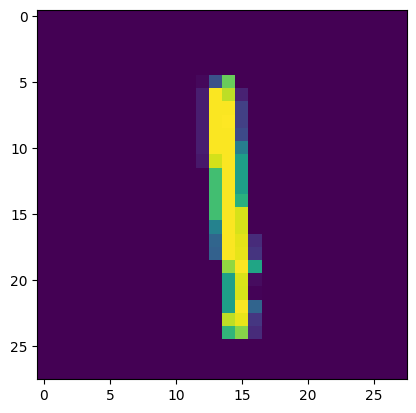

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(data, interpolation='nearest')
plt.show()

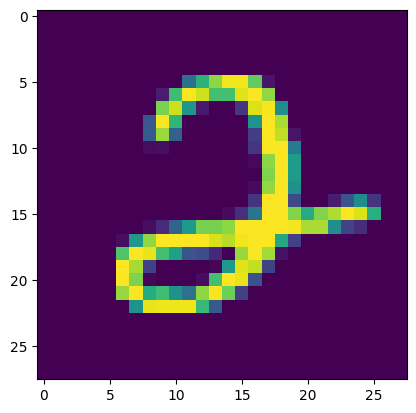

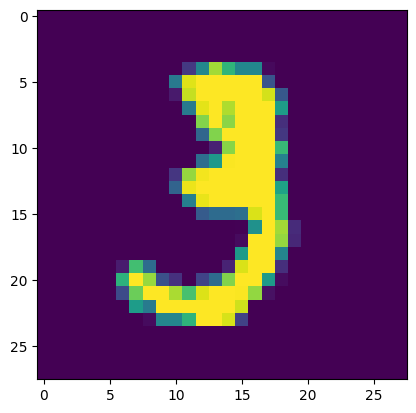

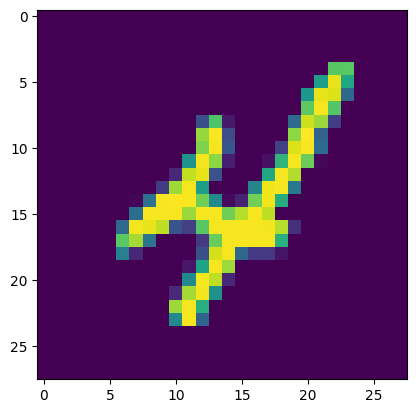

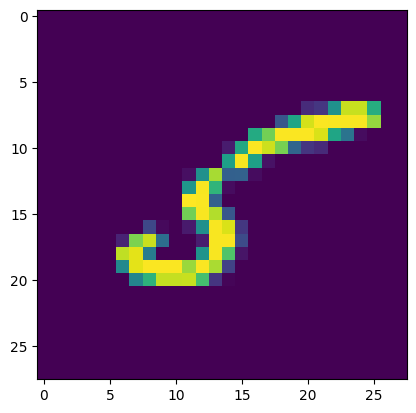

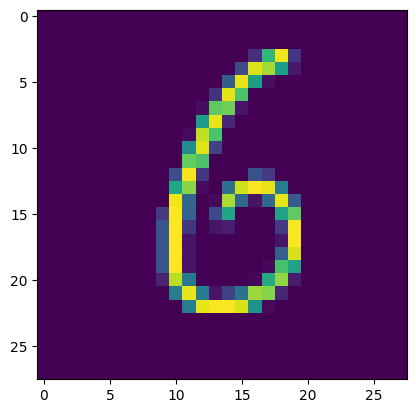

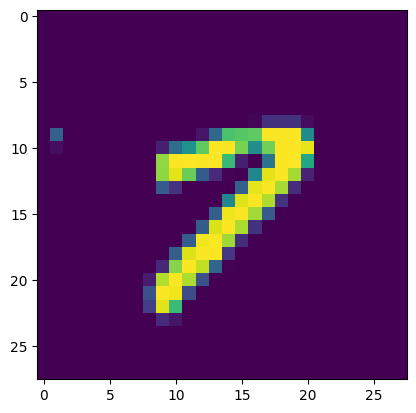

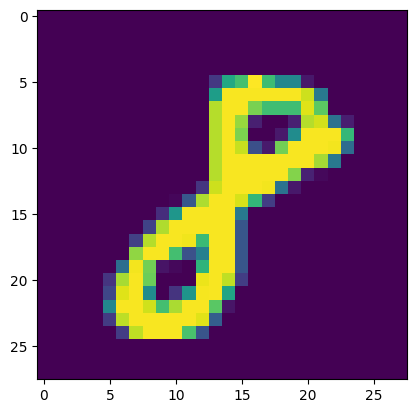

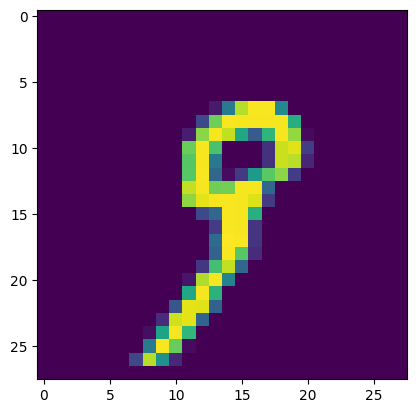

In [ ]:
for i in range(2,10):
  data=classwise_train[i][1][0][-1, :, :].numpy()
  plt.imshow(data, interpolation='nearest')
  plt.show()

### Model

In [ ]:
device = 'cuda'


In [ ]:
model = AllCNN(n_channels = 1).to(device = device)

In [ ]:
epochs = 10 # epochs=25
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

Train the Model

In [ ]:
%%time
history = fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func, device = device)
torch.save(model.state_dict(), "AllCNN_MNIST_ALL_CLASSES.pt")

Epoch [0], last_lr: 0.01000, train_loss: 0.3063, val_loss: 0.3696, val_acc: 0.8646
Epoch [1], last_lr: 0.01000, train_loss: 0.0691, val_loss: 0.1951, val_acc: 0.9361
Epoch [2], last_lr: 0.01000, train_loss: 0.0598, val_loss: 0.1328, val_acc: 0.9579
Epoch [3], last_lr: 0.01000, train_loss: 0.0481, val_loss: 0.1273, val_acc: 0.9608
Epoch [4], last_lr: 0.01000, train_loss: 0.0443, val_loss: 0.0487, val_acc: 0.9853
Epoch [5], last_lr: 0.01000, train_loss: 0.0428, val_loss: 0.0354, val_acc: 0.9893
Epoch [6], last_lr: 0.01000, train_loss: 0.0389, val_loss: 0.1497, val_acc: 0.9520
Epoch [7], last_lr: 0.01000, train_loss: 0.0365, val_loss: 0.0881, val_acc: 0.9747
Epoch [8], last_lr: 0.01000, train_loss: 0.0368, val_loss: 0.0305, val_acc: 0.9903
Epoch [9], last_lr: 0.01000, train_loss: 0.0336, val_loss: 0.1048, val_acc: 0.9672
CPU times: user 3min 18s, sys: 9.44 s, total: 3min 27s
Wall time: 4min 40s


In [ ]:
model_modified = AllCNNModified(n_channels = 1).to(device = device)
history_modified = fit_one_cycle(epochs, max_lr, model_modified, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func, device = device)
torch.save(model_modified.state_dict(), "AllCNN_Modified_MNIST_ALL_CLASSES.pt")

Epoch [0], last_lr: 0.01000, train_loss: 0.3018, val_loss: 0.4356, val_acc: 0.8486
Epoch [1], last_lr: 0.01000, train_loss: 0.0698, val_loss: 0.3408, val_acc: 0.8854
Epoch [2], last_lr: 0.01000, train_loss: 0.0575, val_loss: 0.0677, val_acc: 0.9796
Epoch [3], last_lr: 0.01000, train_loss: 0.0504, val_loss: 0.0571, val_acc: 0.9812
Epoch [4], last_lr: 0.01000, train_loss: 0.0434, val_loss: 0.0455, val_acc: 0.9859
Epoch [5], last_lr: 0.01000, train_loss: 0.0415, val_loss: 0.0408, val_acc: 0.9874
Epoch [6], last_lr: 0.01000, train_loss: 0.0392, val_loss: 0.0658, val_acc: 0.9808
Epoch [7], last_lr: 0.01000, train_loss: 0.0381, val_loss: 0.0502, val_acc: 0.9841
Epoch [8], last_lr: 0.01000, train_loss: 0.0341, val_loss: 0.0622, val_acc: 0.9796
Epoch [9], last_lr: 0.01000, train_loss: 0.0367, val_loss: 0.0591, val_acc: 0.9821
Epoch 00010: reducing learning rate of group 0 to 5.0000e-03.


Validate the model

In [ ]:
model.load_state_dict(torch.load("AllCNN_MNIST_ALL_CLASSES.pt"))
history = [evaluate(model, valid_dl, device = device)]
history

[{'Loss': 0.10484131425619125, 'Acc': 0.9671875238418579}]

In [ ]:
model_modified.load_state_dict(torch.load("AllCNN_Modified_MNIST_ALL_CLASSES.pt"))
history_modified = [evaluate(model_modified, valid_dl, device = device)]
history_modified

[{'Loss': 0.05906060338020325, 'Acc': 0.982128918170929}]

In [ ]:
# Getting the forget and retain data
forget_valid = [] #list of forget class examples with label
forget_classes = [0]
for cls in range(num_classes):
    if cls in forget_classes:
        for img, label in classwise_test[cls]:
            forget_valid.append((img, label))

retain_valid = [] #list of retain class examples with label
for cls in range(num_classes):
    if cls not in forget_classes:
        for img, label in classwise_test[cls]:
            retain_valid.append((img, label))

forget_valid_dl = DataLoader(forget_valid, batch_size, num_workers=3, pin_memory=True)

retain_valid_dl = DataLoader(retain_valid, batch_size, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
n_generator_iter = 1
n_student_iter = 10
n_repeat_batch = n_generator_iter + n_student_iter

In [ ]:
# Create a sample input tensor
sample_input = torch.randn(128, 1, 32, 32).to(device) # Batch size: 128, Filters: 3, Image size: 32x32

# Pass the input through the student
out, actv1, actv2, actv3, actv4, actv5, actv6, actv7, actv8, flattened = model_modified(sample_input)

# Print the shapes of the tensors
print("Student logits shape:", out.shape) # batch_size x total_classes
print("Student hidden representation shape:", flattened.shape) # batch_size x hidden_representation_size


Student logits shape: torch.Size([128, 10])
Student hidden representation shape: torch.Size([128, 192, 8, 8])


In [ ]:
# modified_nn_light = AllCNNModified(num_classes=10).to(device)
modified_nn_light = AllCNNModified(n_channels = 1).to(device = device)

In [ ]:
# # Cosine Loss minimization
# import torch.optim as optim
# def train_cosine_loss(teacher, student, train_loader, epochs, learning_rate, hidden_rep_loss_weight, ce_loss_weight, device):
#     ce_loss = nn.CrossEntropyLoss()
#     cosine_loss = nn.CosineEmbeddingLoss()
#     optimizer = optim.Adam(student.parameters(), lr=learning_rate)

#     teacher.to(device)
#     student.to(device)
#     teacher.eval()  # Teacher set to evaluation mode
#     student.train() # Student to train mode

#     for epoch in range(epochs):
#         running_loss = 0.0
#         for inputs, labels in train_loader:
#             inputs, labels = inputs.to(device), labels.to(device)

#             optimizer.zero_grad()

#             # Forward pass with the teacher model and keep only the hidden representation
#             with torch.no_grad():
#                 _,actv1, actv2, actv3, actv4, actv5, actv6, actv7, actv8, teacher_hidden_representation = teacher(inputs)

#             # Forward pass with the student model
#             student_logits,actv1, actv2, actv3, actv4, actv5, actv6, actv7, actv8, student_hidden_representation = student(inputs)

#             # Calculate the cosine loss. Target is a vector of ones. From the loss formula above we can see that is the case where loss minimization leads to cosine similarity increase.
#             hidden_rep_loss = cosine_loss(student_hidden_representation, teacher_hidden_representation, target=torch.ones(inputs.size(0)).to(device))

#             # Calculate the true label loss
#             label_loss = ce_loss(student_logits, labels)

#             # Weighted sum of the two losses
#             loss = hidden_rep_loss_weight * hidden_rep_loss + ce_loss_weight * label_loss

#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()

#         print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

# # train_cosine_loss(teacher=model_modified, student=modified_nn_light, train_loader=train_dl, epochs=10, learning_rate=0.001, hidden_rep_loss_weight=0.25, ce_loss_weight=0.75, device=device)


RuntimeError: ignored

In [ ]:
def test_multiple_outputs(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs, actv1, actv2, actv3, actv4, actv5, actv6, actv7, actv8, teacher_hidden_representation = model(inputs) # Disregard the second tensor of the tuple
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

test_accuracy_light_ce_and_cosine_loss = test_multiple_outputs(modified_nn_light, valid_dl, device)

# Final student model to train with KT and Cosine similarity

## Original

In [ ]:

# model = AllCNN(n_channels = 1).to(device = device)
# model.load_state_dict(torch.load("AllCNN_MNIST_ALL_CLASSES.pt"))

# student = AllCNN(n_channels = 1).to(device = device)
# generator = LearnableLoader(n_repeat_batch=n_repeat_batch, num_channels = 1, device = device).to(device=device)
# optimizer_generator = torch.optim.Adam(generator.parameters(), lr=0.001)
# scheduler_generator = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_generator,
#                                                                mode='min', factor=0.5, patience=2, verbose=True)
# optimizer_student = torch.optim.Adam(student.parameters(), lr=0.001)
# scheduler_student = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_student,
#                                     mode='min', factor=0.5, patience=2, verbose=True)

## Cosine

In [ ]:
model = AllCNNModified(n_channels = 1).to(device = device)
model.load_state_dict(torch.load("AllCNN_Modified_MNIST_ALL_CLASSES.pt"))

student = AllCNNModified(n_channels = 1).to(device = device)
generator = LearnableLoader(n_repeat_batch=n_repeat_batch, num_channels = 1, device = device).to(device=device)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=0.001)
scheduler_generator = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_generator,
                                                               mode='min', factor=0.5, patience=2, verbose=True)
optimizer_student = torch.optim.Adam(student.parameters(), lr=0.001)
scheduler_student = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_student,
                                    mode='min', factor=0.5, patience=2, verbose=True)

In [ ]:
print("Performance of Fully Trained Model on Forget Class")
history = [evaluate(model, forget_valid_dl, device = device)]
print("Accuracy: {}".format(history[0]["Acc"]*100))
print("Loss: {}".format(history[0]["Loss"]))

print("Performance of Fully Trained Model on Retain Class")
history = [evaluate(model, retain_valid_dl, device = device)]
print("Accuracy: {}".format(history[0]["Acc"]*100))
print("Loss: {}".format(history[0]["Loss"]))


history = [evaluate(student, forget_valid_dl, device = device)]
AccForget = history[0]["Acc"]*100
ErrForget = history[0]["Loss"]

history = [evaluate(student, retain_valid_dl, device = device)]
AccRetain = history[0]["Acc"]*100
ErrRetain = history[0]["Loss"]

Performance of Fully Trained Model on Forget Class
Accuracy: 99.51171875
Loss: 0.026130495592951775
Performance of Fully Trained Model on Retain Class
Accuracy: 97.96224236488342
Loss: 0.06529124826192856


In [ ]:
! rm -r /content/ckpts

rm: cannot remove '/content/ckpts': No such file or directory


In [ ]:
generator_path = "./ckpts/mnist_allcnn/generator"
student_path = "./ckpts/mnist_allcnn/student"

os.makedirs(generator_path)
os.makedirs(student_path)

idx_pseudo = 0
total_n_pseudo_batches = 1000 # number of batches
n_pseudo_batches = 0
running_gen_loss = []
running_stu_loss = []

threshold = 0.01

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
KL_temperature = 1
AT_beta = 250

## Original

In [ ]:
history_forget = [evaluate(student, forget_valid_dl, device = device)]
AccForget = history_forget[0]["Acc"]*100
ErrForget = history_forget[0]["Loss"]

history_retain = [evaluate(student, retain_valid_dl, device = device)]
AccRetain = history_retain[0]["Acc"]*100
ErrRetain = history_retain[0]["Loss"]

df = pd.DataFrame(columns = ["Epochs", "AccForget", "AccRetain", "ErrForget", "ErrRetain", "MeanGeneratorLoss", "MeanStudentLoss"])
df = df.append({"Epochs":0, "AccForget":AccForget, "AccRetain":AccRetain, "ErrForget":ErrForget,
                "ErrRetain":ErrRetain, "MeanGeneratorLoss":None, "MeanStudentLoss":None}, ignore_index = True)

# saving the generator
torch.save(generator.state_dict(), os.path.join(generator_path, str(0) + ".pt"))

# saving the student
torch.save(student.state_dict(), os.path.join(student_path, str(0) + ".pt"))




while n_pseudo_batches < total_n_pseudo_batches:
    x_pseudo = generator.__next__()
    preds, *_ = model(x_pseudo)
    mask = (torch.softmax(preds.detach(), dim=1)[:, 0] <= threshold)
    x_pseudo = x_pseudo[mask]
    if x_pseudo.size(0) == 0:
        zero_count += 1
        if zero_count > 100:
            print("Generator Stopped Producing datapoints corresponding to retain classes.")
            print("Resetting the generator to previous checkpoint")
            generator.load_state_dict(torch.load(os.path.join(generator_path, str(((n_pseudo_batches//50)-1)*50) + ".pt")))
        continue
    else:
        zero_count = 0

    ## Take n_generator_iter steps on generator
    if idx_pseudo % n_repeat_batch < n_generator_iter:
        student_logits, *student_activations = student(x_pseudo)
        teacher_logits, *teacher_activations = model(x_pseudo)
        generator_total_loss = KT_loss_generator(student_logits, teacher_logits, KL_temperature=KL_temperature)

        optimizer_generator.zero_grad()
        generator_total_loss.backward()
        torch.nn.utils.clip_grad_norm_(generator.parameters(), 5)
        optimizer_generator.step()
        running_gen_loss.append(generator_total_loss.cpu().detach())


    elif idx_pseudo % n_repeat_batch < (n_generator_iter + n_student_iter):


        with torch.no_grad():
            teacher_logits, *teacher_activations = model(x_pseudo)

        student_logits, *student_activations = student(x_pseudo)
        student_total_loss = KT_loss_student(student_logits, student_activations,
                                             teacher_logits, teacher_activations,
                                             KL_temperature=KL_temperature, AT_beta = AT_beta)

        optimizer_student.zero_grad()
        student_total_loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 5)
        optimizer_student.step()
        running_stu_loss.append(student_total_loss.cpu().detach())

    if (idx_pseudo + 1) % n_repeat_batch == 0:
        if((n_pseudo_batches)% 50 == 0):
            MeanGLoss = np.mean(running_gen_loss)
            running_gen_loss = []
            MeanSLoss = np.mean(running_stu_loss)
            running_stu_loss = []

            history_forget = [evaluate(student, forget_valid_dl, device = device)]
            AccForget = history_forget[0]["Acc"]*100
            ErrForget = history_forget[0]["Loss"]

            history_retain = [evaluate(student, retain_valid_dl, device = device)]
            AccRetain = history_retain[0]["Acc"]*100
            ErrRetain = history_retain[0]["Loss"]

            df = df.append({"Epochs":n_pseudo_batches, "AccForget":AccForget, "AccRetain":AccRetain, "ErrForget":ErrForget,
                            "ErrRetain":ErrRetain, "MeanGeneratorLoss":MeanGLoss, "MeanStudentLoss":MeanSLoss}, ignore_index = True)
            print(df.iloc[-1:])
            scheduler_student.step(history_retain[0]["Loss"])
            scheduler_generator.step(history[0]["Loss"])

            # saving the generator
            torch.save(generator.state_dict(), os.path.join(generator_path, str(n_pseudo_batches) + ".pt"))

            # saving the student
            torch.save(student.state_dict(), os.path.join(student_path, str(n_pseudo_batches) + ".pt"))


        n_pseudo_batches += 1

    idx_pseudo += 1

## Cosine

In [ ]:
history_forget = [evaluate(student, forget_valid_dl, device = device)]
AccForget = history_forget[0]["Acc"]*100
ErrForget = history_forget[0]["Loss"]

history_retain = [evaluate(student, retain_valid_dl, device = device)]
AccRetain = history_retain[0]["Acc"]*100
ErrRetain = history_retain[0]["Loss"]

df = pd.DataFrame(columns = ["Epochs", "AccForget", "AccRetain", "ErrForget", "ErrRetain", "MeanGeneratorLoss", "MeanStudentLoss"])
df = df.append({"Epochs":0, "AccForget":AccForget, "AccRetain":AccRetain, "ErrForget":ErrForget,
                "ErrRetain":ErrRetain, "MeanGeneratorLoss":None, "MeanStudentLoss":None}, ignore_index = True)

# saving the generator
torch.save(generator.state_dict(), os.path.join(generator_path, str(0) + ".pt"))

# saving the student
torch.save(student.state_dict(), os.path.join(student_path, str(0) + ".pt"))




while n_pseudo_batches < total_n_pseudo_batches:
    x_pseudo = generator.__next__()
    preds, *_ = model(x_pseudo)
    mask = (torch.softmax(preds.detach(), dim=1)[:, 0] <= threshold)
    x_pseudo = x_pseudo[mask]
    if x_pseudo.size(0) == 0:
        zero_count += 1
        if zero_count > 100:
            print("Generator Stopped Producing datapoints corresponding to retain classes.")
            print("Resetting the generator to previous checkpoint")
            generator.load_state_dict(torch.load(os.path.join(generator_path, str(((n_pseudo_batches//50)-1)*50) + ".pt")))
        continue
    else:
        zero_count = 0

    ## Take n_generator_iter steps on generator
    if idx_pseudo % n_repeat_batch < n_generator_iter:
        student_logits, *student_activations = student(x_pseudo)
        teacher_logits, *teacher_activations = model(x_pseudo)
        generator_total_loss = KT_loss_generator(student_logits, teacher_logits, KL_temperature=KL_temperature)

        optimizer_generator.zero_grad()
        generator_total_loss.backward()
        torch.nn.utils.clip_grad_norm_(generator.parameters(), 5)
        optimizer_generator.step()
        running_gen_loss.append(generator_total_loss.cpu().detach())


    elif idx_pseudo % n_repeat_batch < (n_generator_iter + n_student_iter):


        with torch.no_grad():
            teacher_logits,teacher_hidden_representation, *teacher_activations = model(x_pseudo)

        student_logits,student_hidden_representation, *student_activations = student(x_pseudo)
        # KT_loss_student(student_logits, student_activations,student_hidden_representation, teacher_logits, teacher_activations,teacher_hidden_representation,x_pseudo,hidden_rep_loss_weight=0.25, KL_temperature = 1, AT_beta = 250):

        student_total_loss = KT_loss_student(student_logits, student_activations,student_hidden_representation,
                                             teacher_logits, teacher_activations,teacher_hidden_representation,x_pseudo,hidden_rep_loss_weight=0.25,
                                             KL_temperature=KL_temperature, AT_beta = AT_beta)

        optimizer_student.zero_grad()
        student_total_loss.backward()
        torch.nn.utils.clip_grad_norm_(student.parameters(), 5)
        optimizer_student.step()
        running_stu_loss.append(student_total_loss.cpu().detach())

    if (idx_pseudo + 1) % n_repeat_batch == 0:
        if((n_pseudo_batches)% 50 == 0):
            MeanGLoss = np.mean(running_gen_loss)
            running_gen_loss = []
            MeanSLoss = np.mean(running_stu_loss)
            running_stu_loss = []

            history_forget = [evaluate(student, forget_valid_dl, device = device)]
            AccForget = history_forget[0]["Acc"]*100
            ErrForget = history_forget[0]["Loss"]

            history_retain = [evaluate(student, retain_valid_dl, device = device)]
            AccRetain = history_retain[0]["Acc"]*100
            ErrRetain = history_retain[0]["Loss"]

            df = df.append({"Epochs":n_pseudo_batches, "AccForget":AccForget, "AccRetain":AccRetain, "ErrForget":ErrForget,
                            "ErrRetain":ErrRetain, "MeanGeneratorLoss":MeanGLoss, "MeanStudentLoss":MeanSLoss}, ignore_index = True)
            print(df.iloc[-1:])
            scheduler_student.step(history_retain[0]["Loss"])
            scheduler_generator.step(history[0]["Loss"])

            # saving the generator
            torch.save(generator.state_dict(), os.path.join(generator_path, str(n_pseudo_batches) + ".pt"))

            # saving the student
            torch.save(student.state_dict(), os.path.join(student_path, str(n_pseudo_batches) + ".pt"))


        n_pseudo_batches += 1

    idx_pseudo += 1

   Epochs  AccForget  AccRetain  ErrForget  ErrRetain  MeanGeneratorLoss  \
1     0.0        0.0  10.655382   2.204775   2.352557          -0.218178   

   MeanStudentLoss  
1         7.967319  
   Epochs  AccForget  AccRetain  ErrForget  ErrRetain  MeanGeneratorLoss  \
2    50.0        0.0   43.14236   6.891189   1.732416           -0.09333   

   MeanStudentLoss  
2         1.442084  
   Epochs  AccForget  AccRetain  ErrForget  ErrRetain  MeanGeneratorLoss  \
3   100.0        0.0  49.784434  10.886833   1.476803          -0.039945   

   MeanStudentLoss  
3         0.580565  
   Epochs  AccForget  AccRetain  ErrForget  ErrRetain  MeanGeneratorLoss  \
4   150.0        0.0  82.933307   9.533777   0.512564          -0.023569   

   MeanStudentLoss  
4         0.309454  
Epoch 00004: reducing learning rate of group 0 to 5.0000e-04.
   Epochs  AccForget  AccRetain  ErrForget  ErrRetain  MeanGeneratorLoss  \
5   200.0        0.0  85.589558   5.474618   0.315979          -0.018279   

   Me

In [ ]:
df

,Epochs,AccForget,AccRetain,ErrForget,ErrRetain,MeanGeneratorLoss,MeanStudentLoss
0,0.0,100.000000,0.000000,2.260243,2.307550,NaN,NaN
1,0.0,0.000000,10.655382,2.204775,2.352557,-0.218178,7.967319
2,50.0,0.000000,43.142360,6.891189,1.732416,-0.093330,1.442084
3,100.0,0.000000,49.784434,10.886833,1.476803,-0.039945,0.580565
4,150.0,0.000000,82.933307,9.533777,0.512564,-0.023569,0.309454
5,200.0,0.000000,85.589558,5.474618,0.315979,-0.018279,0.202988
6,250.0,0.000000,97.308308,3.528170,0.171851,-0.014192,0.151384
7,300.0,23.085569,96.136433,1.969378,0.156305,-0.011293,0.101337
8,350.0,81.001252,97.615021,0.685759,0.107713,-0.015575,0.104062
9,400.0,92.290688,97.484809,0.328692,0.107755,-0.018111,0.093435


from matplotlib import pyplot as plt
df['Epochs'].plot(kind='hist', bins=20, title='Epochs')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['AccForget'].plot(kind='hist', bins=20, title='AccForget')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['AccRetain'].plot(kind='hist', bins=20, title='AccRetain')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['ErrForget'].plot(kind='hist', bins=20, title='ErrForget')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Epochs', y='AccForget', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='AccForget', y='AccRetain', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='AccRetain', y='ErrForget', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='ErrForget', y='ErrRetain', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Epochs']
  ys = series['AccForget']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Epochs', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Epochs')
_ = plt.ylabel('AccForget')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Epochs']
  ys = series['AccRetain']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Epochs', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Epochs')
_ = plt.ylabel('AccRetain')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Epochs']
  ys = series['ErrForget']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Epochs', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Epochs')
_ = plt.ylabel('ErrForget')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Epochs']
  ys = series['ErrRetain']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Epochs', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Epochs')
_ = plt.ylabel('ErrRetain')

from matplotlib import pyplot as plt
df['Epochs'].plot(kind='line', figsize=(8, 4), title='Epochs')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['AccForget'].plot(kind='line', figsize=(8, 4), title='AccForget')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['AccRetain'].plot(kind='line', figsize=(8, 4), title='AccRetain')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['ErrForget'].plot(kind='line', figsize=(8, 4), title='ErrForget')
plt.gca().spines[['top', 'right']].set_visible(False)

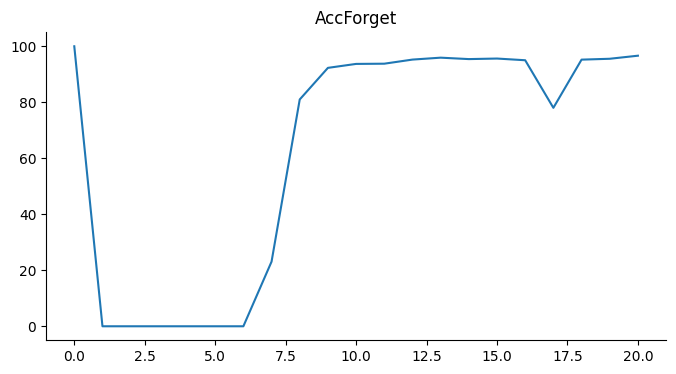

In [ ]:
from matplotlib import pyplot as plt
df['AccForget'].plot(kind='line', figsize=(8, 4), title='AccForget')
plt.gca().spines[['top', 'right']].set_visible(False)

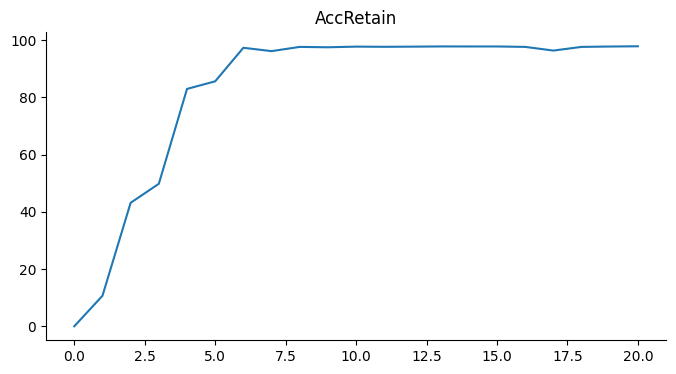

In [ ]:
from matplotlib import pyplot as plt
df['AccRetain'].plot(kind='line', figsize=(8, 4), title='AccRetain')
plt.gca().spines[['top', 'right']].set_visible(False)

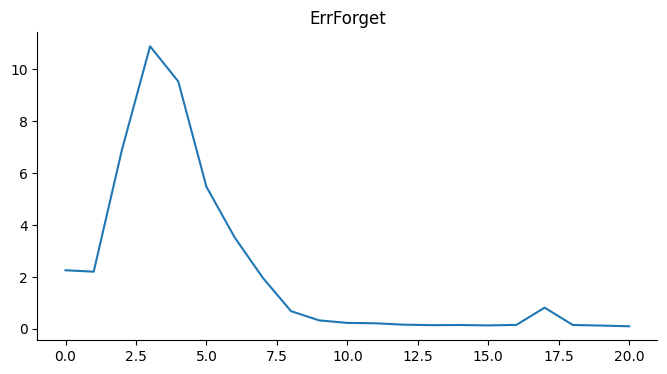

In [ ]:
from matplotlib import pyplot as plt
df['ErrForget'].plot(kind='line', figsize=(8, 4), title='ErrForget')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
df.to_csv("MNIST_ALLCNN_Modified.csv", index = False)

In [ ]:
!zip -r /content/file.zip /content/ckpts

  adding: content/ckpts/ (stored 0%)
  adding: content/ckpts/mnist_allcnn/ (stored 0%)
  adding: content/ckpts/mnist_allcnn/student/ (stored 0%)
  adding: content/ckpts/mnist_allcnn/student/500.pt (deflated 7%)
  adding: content/ckpts/mnist_allcnn/student/250.pt (deflated 7%)
  adding: content/ckpts/mnist_allcnn/student/850.pt (deflated 7%)
  adding: content/ckpts/mnist_allcnn/student/750.pt (deflated 7%)
  adding: content/ckpts/mnist_allcnn/student/450.pt (deflated 7%)
  adding: content/ckpts/mnist_allcnn/student/150.pt (deflated 8%)
  adding: content/ckpts/mnist_allcnn/student/700.pt (deflated 7%)
  adding: content/ckpts/mnist_allcnn/student/550.pt (deflated 7%)
  adding: content/ckpts/mnist_allcnn/student/300.pt (deflated 7%)
  adding: content/ckpts/mnist_allcnn/student/50.pt (deflated 8%)
  adding: content/ckpts/mnist_allcnn/student/650.pt (deflated 7%)
  adding: content/ckpts/mnist_allcnn/student/950.pt (deflated 7%)
  adding: content/ckpts/mnist_allcnn/student/400.pt (deflated 7%

In [ ]:
import pandas as pd
df = pd.read_csv('/content/MNIST_ALLCNN (1).csv')
df

,Epochs,AccForget,AccRetain,ErrForget,ErrRetain,MeanGeneratorLoss,MeanStudentLoss
0,0.0,0.000000,10.394965,2.274930,2.306609,NaN,NaN
1,0.0,0.000000,10.568576,4.399641,3.346967,-0.219344,8.095344
2,50.0,0.000000,71.321613,8.068534,1.275517,-0.072994,1.562847
3,100.0,0.000000,83.355033,5.815036,0.841155,-0.019644,0.201711
4,150.0,0.000000,84.385848,3.335475,0.863327,-0.016014,0.114951
5,200.0,0.000000,85.091144,2.708343,0.843004,-0.006828,0.052483
6,250.0,5.162883,85.264754,2.331839,0.799049,-0.008461,0.053746
7,300.0,42.351490,85.394967,1.578632,0.837961,-0.005350,0.036945
8,350.0,62.164652,85.460067,1.156465,0.807321,-0.005343,0.037400
9,400.0,71.126914,85.536027,0.977192,0.789086,-0.007027,0.035050


from matplotlib import pyplot as plt
df['Epochs'].plot(kind='hist', bins=20, title='Epochs')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['AccForget'].plot(kind='hist', bins=20, title='AccForget')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['AccRetain'].plot(kind='hist', bins=20, title='AccRetain')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['ErrForget'].plot(kind='hist', bins=20, title='ErrForget')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Epochs', y='AccForget', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='AccForget', y='AccRetain', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='AccRetain', y='ErrForget', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='ErrForget', y='ErrRetain', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Epochs']
  ys = series['AccRetain']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Epochs', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Epochs')
_ = plt.ylabel('AccRetain')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Epochs']
  ys = series['ErrForget']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Epochs', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Epochs')
_ = plt.ylabel('ErrForget')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Epochs']
  ys = series['ErrRetain']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Epochs', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Epochs')
_ = plt.ylabel('ErrRetain')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Epochs']
  ys = series['MeanGeneratorLoss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Epochs', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Epochs')
_ = plt.ylabel('MeanGeneratorLoss')

from matplotlib import pyplot as plt
df['Epochs'].plot(kind='line', figsize=(8, 4), title='Epochs')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['AccForget'].plot(kind='line', figsize=(8, 4), title='AccForget')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['AccRetain'].plot(kind='line', figsize=(8, 4), title='AccRetain')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['ErrForget'].plot(kind='line', figsize=(8, 4), title='ErrForget')
plt.gca().spines[['top', 'right']].set_visible(False)

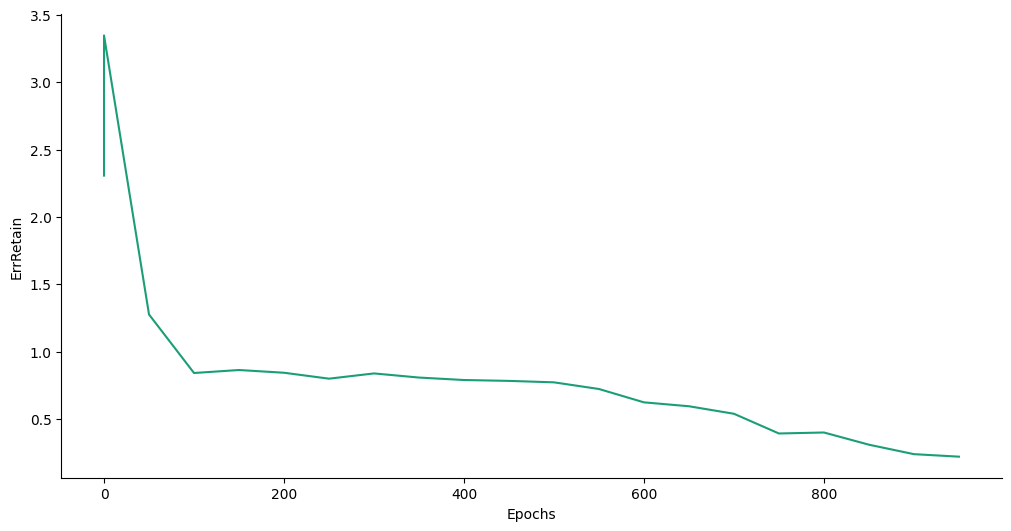

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Epochs']
  ys = series['ErrRetain']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Epochs', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Epochs')
_ = plt.ylabel('ErrRetain')

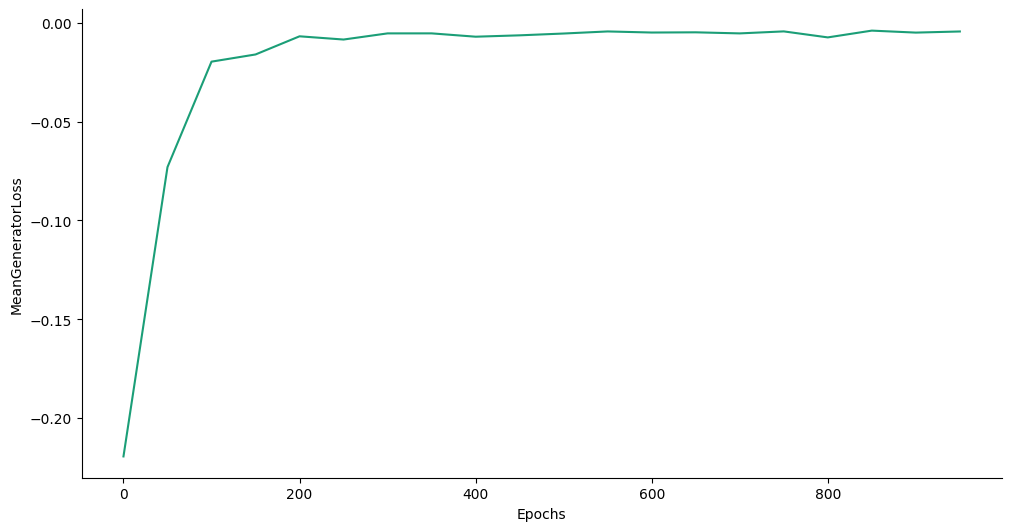

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Epochs']
  ys = series['MeanGeneratorLoss']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Epochs', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Epochs')
_ = plt.ylabel('MeanGeneratorLoss')

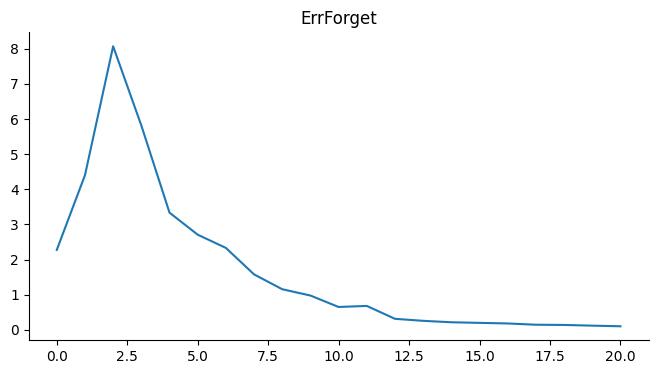

In [ ]:
from matplotlib import pyplot as plt
df['ErrForget'].plot(kind='line', figsize=(8, 4), title='ErrForget')
plt.gca().spines[['top', 'right']].set_visible(False)

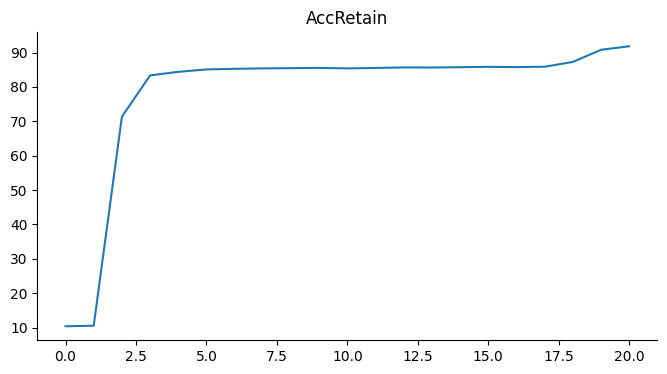

In [ ]:
from matplotlib import pyplot as plt
df['AccRetain'].plot(kind='line', figsize=(8, 4), title='AccRetain')
plt.gca().spines[['top', 'right']].set_visible(False)

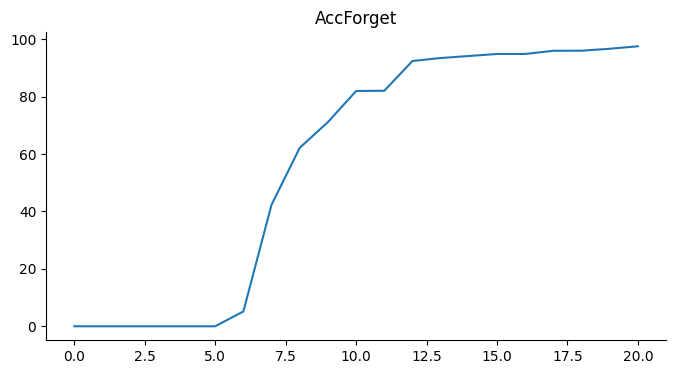

In [ ]:
from matplotlib import pyplot as plt
df['AccForget'].plot(kind='line', figsize=(8, 4), title='AccForget')
plt.gca().spines[['top', 'right']].set_visible(False)